In [ ]:
#import libraries
import pandas as pd
# scaler
from sklearn.preprocessing import MinMaxScaler
# k-means
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.metrics import silhouette_score
# PCA
from sklearn.decomposition import PCA
# SVM
from sklearn import svm
# KNN
from sklearn.neighbors import KNeighborsClassifier
# model tuning
from sklearn.model_selection import GridSearchCV
# plot
import matplotlib.pyplot as plt
# metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score

In [ ]:
# import files (extra)
folder = "../../data/"

x_train = pd.read_csv(folder + "x_train_extra.csv")
x_test = pd.read_csv(folder + "x_test_extra.csv")
x_valid = pd.read_csv(folder + "x_valid_extra.csv")

y_train = pd.read_csv(folder + "y_train_extra.csv", dtype=int)
y_test = pd.read_csv(folder + "y_test_extra.csv", dtype=int)
y_valid = pd.read_csv(folder + "y_valid_extra.csv", dtype=int)

In [ ]:
### Unsupervised method does not need validation set
x_train_all = pd.concat([x_train, x_valid])
y_train_all = pd.concat([y_train, y_valid])
print(x_train_all.shape)

(4869, 77)


In [ ]:
# Scale features
scaler = MinMaxScaler()
x_train_all = scaler.fit_transform(x_train_all)
x_test = scaler.transform(x_test)

# K-means

In [ ]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 0,
}

# A list holds the SSE values for each k
sse = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(x_train)
    sse.append(kmeans.inertia_)

Text(0, 0.5, 'SSE')

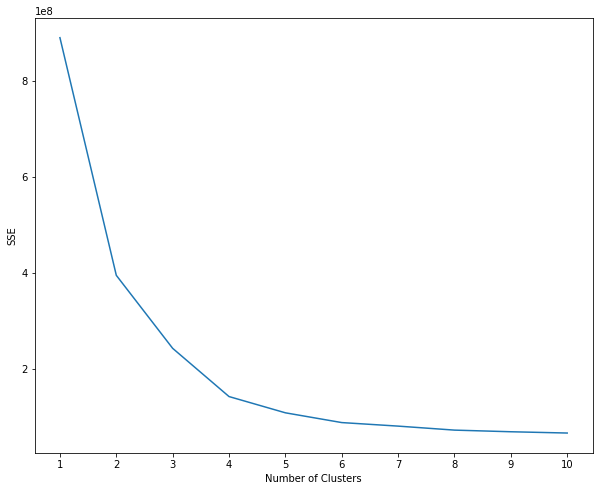

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(range(1, 11), sse);
plt.xticks(range(1, 11));
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")

In [ ]:
# Logic - Fraudulent cases might have similar patterns to be clustered together
kmeans = KMeans(n_clusters=2)
kmeans.fit(x_train_all)
y_kmeans = kmeans.predict(x_train_all)
y_pred_all = list(map(lambda x: 1-x, y_kmeans))
# Evaluation on Train set
print('Precision: ', precision_score(y_train_all, y_pred_all))
print('Recall: ', recall_score(y_train_all, y_pred_all))
print('Accuracy: ', accuracy_score(y_train_all, y_pred_all))
print('F1 score: ', f1_score(y_train_all, y_pred_all))

Precision:  0.0741777466759972
Recall:  0.7035398230088495
Accuracy:  0.15732183199835695
F1 score:  0.13420552859253007


In [ ]:
y_kmeans_test = kmeans.predict(x_test)
y_pred_test = list(map(lambda x: 1-x, y_kmeans_test))
# Evaluation on Test set
print('Precision: ', precision_score(y_test, y_pred_test))
print('Recall: ', recall_score(y_test, y_pred_test))
print('Accuracy: ', accuracy_score(y_test, y_pred_test))
print('F1 score: ', f1_score(y_test, y_pred_test)) # Higher recall??? 

Precision:  0.07983193277310924
Recall:  0.7037037037037037
Accuracy:  0.16081330868761554
F1 score:  0.14339622641509434


# PCA

In [ ]:
# PCA dimension deduction to 2 dimensions for visualization
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_train_all)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head()

,principal component 1,principal component 2
0,-0.229729,0.109746
1,0.025649,0.101413
2,-0.158604,-0.293415
3,-0.173103,-0.200284
4,-0.305995,-0.110103


In [ ]:
y_train_all.reset_index(inplace=True, drop=True)
finalDf = pd.concat([principalDf, y_train_all], axis = 1)
finalDf.head()

,principal component 1,principal component 2,PotentialFraud
0,-0.229729,0.109746,0
1,0.025649,0.101413,0
2,-0.158604,-0.293415,0
3,-0.173103,-0.200284,1
4,-0.305995,-0.110103,0


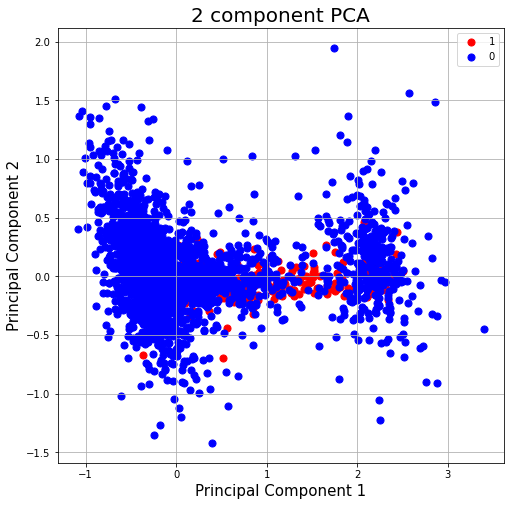

In [ ]:
# Plot
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1, 0]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['PotentialFraud'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

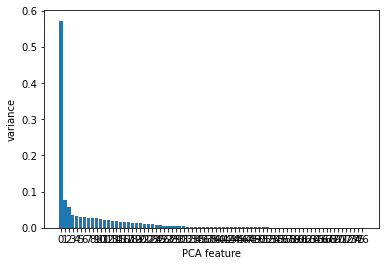

In [ ]:
# Fit pca to 'X'
pca = PCA()
pca.fit(x_train_all)

# Plot the explained variances
features = range(0, pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

# SVM

In [ ]:
# Cross Validation of SVM
params = {
    'C': [0.1, 10, 1000],
    'gamma': [10, 1, 0.01],
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'class_weight':['balanced'],
    'random_state':[1]
}

clf = GridSearchCV(
    estimator=svm.SVC(),
    param_grid=params,
    cv=5,
    n_jobs=5,
    verbose=1,
    scoring = 'f1'
)

clf.fit(x_train_all, y_train_all)
print(clf.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


C:\Users\Fangzhou\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


{'C': 1000, 'class_weight': 'balanced', 'gamma': 10, 'kernel': 'linear', 'random_state': 1}


In [ ]:
#Create a svm Classifier
clf = svm.SVC(C=1000, class_weight = 'balanced', gamma=10,kernel = 'linear',random_state=1) # best

#Train the model using the training sets
clf.fit(x_train_all, y_train_all)

#Predict the response for test dataset
y_pred_train = clf.predict(x_train_all)
y_pred_test = clf.predict(x_test) 

# Evaluation on Train
print ('Evaluation on Train:')
print('Precision: ', precision_score(y_train_all, y_pred_train))
print('Recall: ', recall_score(y_train_all, y_pred_train))
print('Accuracy: ', accuracy_score(y_train_all, y_pred_train))
print('F1 score: ', f1_score(y_train_all, y_pred_train))
print('AUC: ', roc_auc_score(y_train_all, y_pred_train))
print('')

# Evaluation on Test
print ('Evaluation on Test:')
print('Precision: ', precision_score(y_test, y_pred_test))
print('Recall: ', recall_score(y_test, y_pred_test))
print('Accuracy: ', accuracy_score(y_test, y_pred_test))
print('F1 score: ', f1_score(y_test, y_pred_test))
print('AUC: ', roc_auc_score(y_test, y_pred_test))

C:\Users\Fangzhou\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Evaluation on Train:
Precision:  0.4130675526024363
Recall:  0.8252212389380531
Accuracy:  0.8749229821318546
F1 score:  0.5505535055350554
AUC:  0.8526151474291804

Evaluation on Test:
Precision:  0.4205607476635514
Recall:  0.8333333333333334
Accuracy:  0.8687615526802218
F1 score:  0.5590062111801242
AUC:  0.8530116358658454


# KNN

In [ ]:
grid_params = { 'n_neighbors' : [1,3,5,7,9],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

knn_model = GridSearchCV(
    estimator=KNeighborsRegressor(),
    param_grid=grid_params,
    cv=5,
    n_jobs=5,
    verbose=1,
    scoring = 'f1'
)

knn_model.fit(x_train_all, y_train_all)
print(knn_model.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
{'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}


C:\Users\Fangzhou\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.4160344  0.4160344         nan        nan        nan        nan
        nan        nan        nan        nan 0.4160344  0.4160344
        nan        nan        nan        nan        nan        nan
        nan        nan 0.43560102 0.43560102        nan        nan
        nan        nan        nan        nan        nan        nan]
  warnings.warn(


In [ ]:
knn_model = KNeighborsRegressor(metric='manhattan',n_neighbors=1,weights='uniform')
knn_model.fit(x_train_all, y_train_all)

#Predict the response for test dataset
y_pred_train = knn_model.predict(x_train_all)
y_pred_test = knn_model.predict(x_test)

# Evaluation on Train
print ('Evaluation on Train:')
print('Precision: ', precision_score(y_train_all, y_pred_train))
print('Recall: ', recall_score(y_train_all, y_pred_train))
print('Accuracy: ', accuracy_score(y_train_all, y_pred_train))
print('F1 score: ', f1_score(y_train_all, y_pred_train))
print('AUC: ', roc_auc_score(y_train_all, y_pred_train))
print('')

# Evaluation on Test
print ('Evaluation on Test:')
print('Precision: ', precision_score(y_test, y_pred_test))
print('Recall: ', recall_score(y_test, y_pred_test))
print('Accuracy: ', accuracy_score(y_test, y_pred_test))
print('F1 score: ', f1_score(y_test, y_pred_test))
print('AUC: ', roc_auc_score(y_test, y_pred_test))

Evaluation on Train:
Precision:  1.0
Recall:  1.0
Accuracy:  1.0
F1 score:  1.0
AUC:  1.0

Evaluation on Test:
Precision:  0.4727272727272727
Recall:  0.48148148148148145
Accuracy:  0.8946395563770795
F1 score:  0.4770642201834862
AUC:  0.710966613430679
